In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 1) Load the dataset
CSV_PATH = "Preprocessed ICU data.csv"   # Adjust if your file is in another location
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()

# 2) Basic check
required_cols = ["ICUType4", "In.hospital_death", "Gender"]
missing = [c for c in required_cols if c not in df.columns]
assert not missing, f"Missing required columns: {missing}"

# 3) Keep only ICU Type 4 rows
df_icu4 = df[df["ICUType4"] == 1].copy()

print(f"ICU Type 4 sample size: {df_icu4.shape[0]} rows, {df_icu4.shape[1]} columns")


ICU Type 4 sample size: 342 rows, 232 columns


In [4]:
# Summary statistics for numeric columns
desc = df_icu4.describe(include=[np.number]).T
desc_path = "icu4_summary_stats.csv"
desc.to_csv(desc_path, index=True)
print(f"Exported summary statistics: {desc_path}")

# Mortality rate
mortality_rate = df_icu4["In.hospital_death"].mean()
print(f"ICU Type 4 mortality rate: {mortality_rate:.3f}  (~ {mortality_rate*100:.1f}%)")

# Gender distribution
gender_counts = df_icu4["Gender"].value_counts(dropna=False)
gender_prop = (gender_counts / gender_counts.sum()).round(3)
print("Gender distribution (counts):\n", gender_counts)
print("Gender distribution (proportions):\n", gender_prop)

# Export quick summary
summary = pd.DataFrame({
    "metric": ["n_icu4", "mortality_rate"],
    "value": [len(df_icu4), mortality_rate]
})
summary_path = "icu4_key_summary.csv"
summary.to_csv(summary_path, index=False)
print(f"Exported key summary: {summary_path}")


Exported summary statistics: icu4_summary_stats.csv
ICU Type 4 mortality rate: 0.453  (~ 45.3%)
Gender distribution (counts):
 Gender
1.000000    188
0.000000    153
0.561921      1
Name: count, dtype: int64
Gender distribution (proportions):
 Gender
1.000000    0.550
0.000000    0.447
0.561921    0.003
Name: count, dtype: float64
Exported key summary: icu4_key_summary.csv


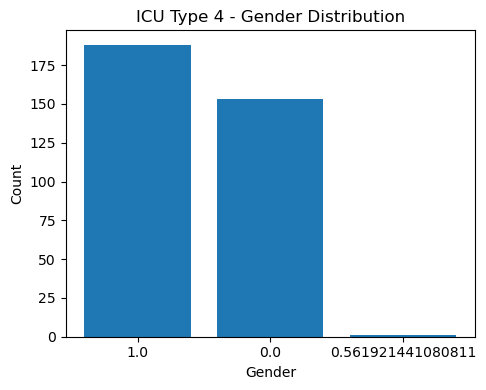

Saved: icu4_figs\icu4_gender_bar.png


In [6]:
# Output directory for figures
out_dir = Path("icu4_figs")
out_dir.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(5,4))
labels = gender_counts.index.astype(str).tolist()
values = gender_counts.values.tolist()
plt.bar(labels, values)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("ICU Type 4 - Gender Distribution")
plt.tight_layout()
fig_gender = out_dir / "icu4_gender_bar.png"
plt.savefig(fig_gender, dpi=150)
plt.show()
print(f"Saved: {fig_gender}")


Columns selected for boxplots: {'Mean_HR': 'Mean_HR.x', 'Mean_GCS': 'Mean_GCS.x', 'BUN': 'Mean_BUN.x', 'Glucose': 'Mean_Glucose.x', 'Max_Lactate': 'Max_Lactate.y'}


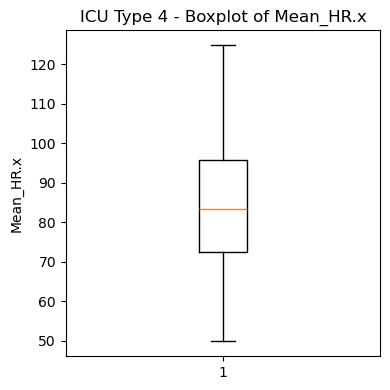

Saved: icu4_figs\icu4_box_Mean_HR.x.png


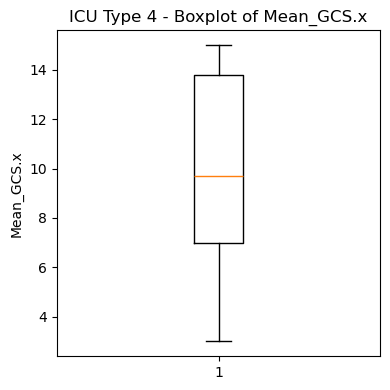

Saved: icu4_figs\icu4_box_Mean_GCS.x.png


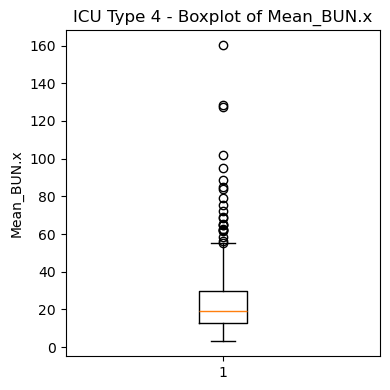

Saved: icu4_figs\icu4_box_Mean_BUN.x.png


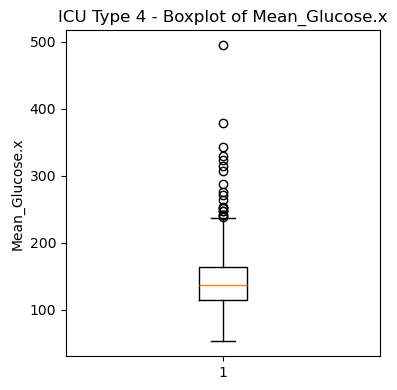

Saved: icu4_figs\icu4_box_Mean_Glucose.x.png


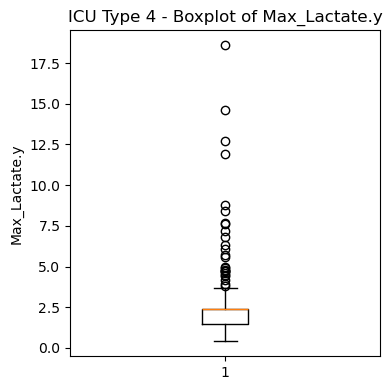

Saved: icu4_figs\icu4_box_Max_Lactate.y.png


In [8]:
# Candidate columns (auto-detect which exist in your dataset)
candidates_map = {
    "Mean_HR":     ["Mean_HR.x", "Mean_HR.y", "HR", "Mean_HR"],
    "Mean_GCS":    ["Mean_GCS.x", "Mean_GCS.y", "GCS", "Mean_GCS"],
    "BUN":         ["BUN", "Mean_BUN.x", "Mean_BUN.y"],
    "Glucose":     ["Glucose", "Mean_Glucose.x", "Mean_Glucose.y"],
    "Max_Lactate": ["Max_Lactate.y", "Max_Lactate.x", "Lactate", "Mean_Lactate.x", "Mean_Lactate.y"]
}

# Find existing columns
picked_cols = {}
for k, cand_list in candidates_map.items():
    for c in cand_list:
        if c in df_icu4.columns:
            picked_cols[k] = c
            break

print("Columns selected for boxplots:", picked_cols)

# Create boxplots
for k, col in picked_cols.items():
    series = pd.to_numeric(df_icu4[col], errors="coerce").dropna()
    if series.empty:
        continue
    plt.figure(figsize=(4,4))
    plt.boxplot(series, vert=True, showfliers=True)
    plt.ylabel(col)
    plt.title(f"ICU Type 4 - Boxplot of {col}")
    plt.tight_layout()
    path = out_dir / f"icu4_box_{col.replace('/', '_')}.png"
    plt.savefig(path, dpi=150)
    plt.show()
    print(f"Saved: {path}")


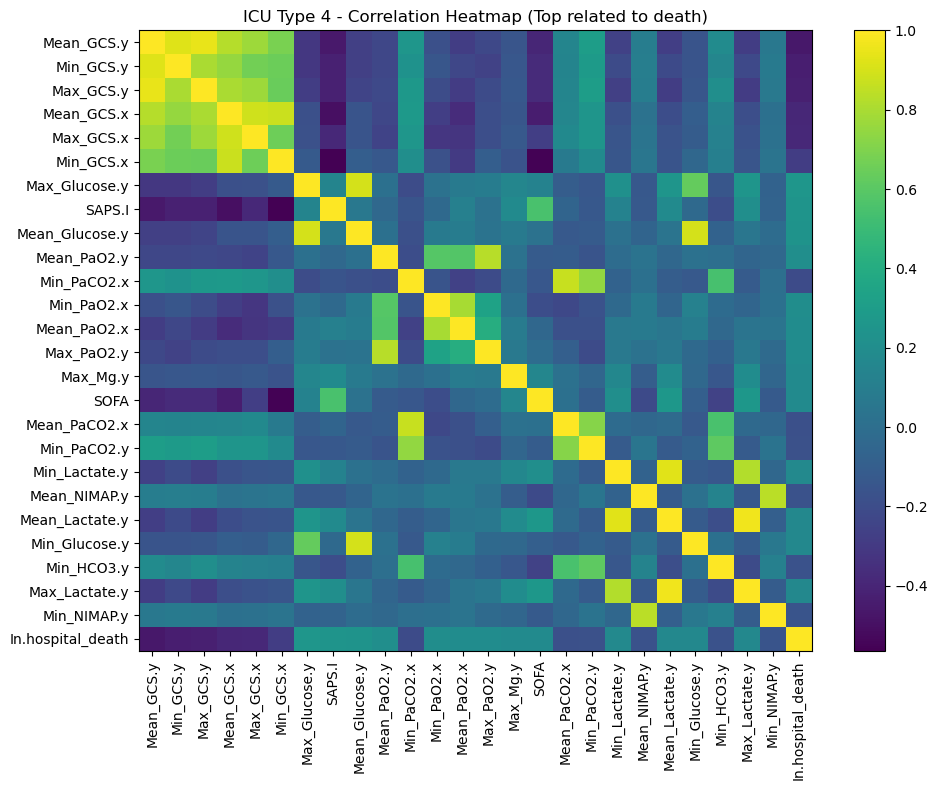

Saved: icu4_figs\icu4_corr_heatmap.png


In [10]:
# Numeric columns only
num_df = df_icu4.select_dtypes(include=[np.number]).copy()

# Drop constant columns
constant_cols = [c for c in num_df.columns if num_df[c].nunique(dropna=True) <= 1]
num_df = num_df.drop(columns=constant_cols, errors="ignore")

# Correlation with target
with_target = num_df.drop(columns=["In.hospital_death"], errors="ignore").corrwith(num_df["In.hospital_death"]).abs()
topk = 25 if len(with_target) >= 25 else len(with_target)
top_features = with_target.sort_values(ascending=False).head(topk).index.tolist()

# Correlation matrix
corr_cols = top_features + ["In.hospital_death"]
corr_mat = num_df[corr_cols].corr()

# Heatmap
plt.figure(figsize=(10,8))
im = plt.imshow(corr_mat.values, aspect='auto')
plt.colorbar(im)
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title("ICU Type 4 - Correlation Heatmap (Top related to death)")
plt.tight_layout()
heatmap_path = out_dir / "icu4_corr_heatmap.png"
plt.savefig(heatmap_path, dpi=150)
plt.show()
print(f"Saved: {heatmap_path}")


In [12]:
# IQR method for outliers on picked columns
iqr_report = []
for k, col in picked_cols.items():
    s = pd.to_numeric(df_icu4[col], errors="coerce").dropna()
    if s.empty:
        continue
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    outliers = ((s < low) | (s > high)).sum()
    iqr_report.append({
        "feature_display": k,
        "column": col,
        "n": s.size,
        "outliers": int(outliers),
        "rate": round(outliers/s.size, 3)
    })

iqr_df = pd.DataFrame(iqr_report).sort_values("rate", ascending=False)
iqr_path = "icu4_iqr_outliers.csv"
iqr_df.to_csv(iqr_path, index=False)
print(f"Exported IQR outlier report: {iqr_path}")
iqr_df


Exported IQR outlier report: icu4_iqr_outliers.csv


,feature_display,column,n,outliers,rate
4,Max_Lactate,Max_Lactate.y,342,26,0.076
2,BUN,Mean_BUN.x,342,23,0.067
3,Glucose,Mean_Glucose.x,342,19,0.056
0,Mean_HR,Mean_HR.x,342,0,0.000
1,Mean_GCS,Mean_GCS.x,342,0,0.000


In [14]:
print("=== Quick Points for Slides ===")
print(f"- ICU4 sample size: {len(df_icu4)}")
print(f"- Mortality rate: {mortality_rate:.1%}")
print(f"- Gender distribution (proportions): {gender_prop.to_dict()}")
print(f"- Columns used for boxplots: {picked_cols}")
print(f"- Correlation heatmap file: {heatmap_path}")
print(f"- Summary statistics CSV: icu4_summary_stats.csv")
print(f"- Outlier report CSV: icu4_iqr_outliers.csv")


=== Quick Points for Slides ===
- ICU4 sample size: 342
- Mortality rate: 45.3%
- Gender distribution (proportions): {1.0: 0.55, 0.0: 0.447, 0.561921441080811: 0.003}
- Columns used for boxplots: {'Mean_HR': 'Mean_HR.x', 'Mean_GCS': 'Mean_GCS.x', 'BUN': 'Mean_BUN.x', 'Glucose': 'Mean_Glucose.x', 'Max_Lactate': 'Max_Lactate.y'}
- Correlation heatmap file: icu4_figs\icu4_corr_heatmap.png
- Summary statistics CSV: icu4_summary_stats.csv
- Outlier report CSV: icu4_iqr_outliers.csv
